In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import statsmodels.formula.api as smf
import copy
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from functools import reduce
import numpy as np
#import ee
#import geemap
import geopandas as gpd
import rioxarray as rxr
import rasterstats as rs
from rasterio.plot import show
import rasterio
import cartopy.crs as ccrs
import gdal
import xarray
%matplotlib inline
plt.rcParams["font.family"] = "Arial"
xarray.set_options(keep_attrs=True)

In [2]:
ndvi_irri = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/ndvi_irrigated.csv')[['ADM3_EN','yr1','yr5']]
ndvi_rf =pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/ndvi_rainfed.csv')[['ADM3_EN','yr1','yr5']]
ndvi_all = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/ndvi_all.csv')[['ADM3_EN','yr1','yr5']]
#ndvi_all

In [3]:
et = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/et.tif')
lstday = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/lstday.tif')
lstnight = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/lstnight.tif')
pcp = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/pcp.tif')
pet = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/pet.tif')
ndvi = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/ndvi.tif')
slope = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/rproj_slope.tif')
elevation = rxr.open_rasterio('/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/rproj_elevation.tif')

In [4]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )


In [5]:
ndvi

<xarray.DataArray (band: 1, y: 519, x: 596)>
[309324 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 1.287e+06 1.286e+06 ... 1.157e+06 1.157e+06
  * x            (x) float64 3.919e+05 3.921e+05 ... 5.404e+05 5.406e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [6]:
slope_repr_match = slope.rio.reproject_match(ndvi)
elevation_repr_match = elevation.rio.reproject_match(ndvi)

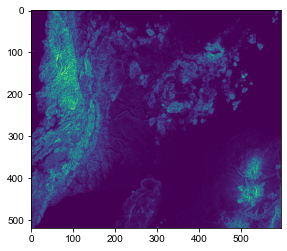

<AxesSubplot:>

In [7]:
et.name = 'et'
lstday.name = 'lstday'
lstnight.name = 'lstnight'
pcp.name = 'pcp'
pet.name = 'pet'
ndvi.name = 'ndvi'
slope_repr_match.name = 'slope'
elevation_repr_match.name = 'elevation'

params= xarray.merge([
    pcp, 
    #lstday, 
    lstnight, 
    et, 
    #pet, 
    #slope_repr_match, 
    elevation_repr_match
])
show(slope_repr_match)

In [8]:
#params.to_array().values.shape

In [9]:
'''#PARAMETERS
params_indexes = params.stack(z=['x','y']).indexes['z']
X_img = np.rot90(params.stack(z=['x','y']).to_array().values.squeeze())
X_img

#NDVI
ndvi_indexes = ndvi.stack(z=['x','y']).indexes['z']
y_img = ndvi.stack(z=['x','y']).values.squeeze()
y_img
'''

"#PARAMETERS\nparams_indexes = params.stack(z=['x','y']).indexes['z']\nX_img = np.rot90(params.stack(z=['x','y']).to_array().values.squeeze())\nX_img\n\n#NDVI\nndvi_indexes = ndvi.stack(z=['x','y']).indexes['z']\ny_img = ndvi.stack(z=['x','y']).values.squeeze()\ny_img\n"

In [10]:
spatial_ref = params['spatial_ref']


# 5 YEAR INCREMENTS
## Irrigated Rice


In [11]:
points = '/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/intersect_DS_5yr.shp'
#points = '/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out2017/intersect_DS_2017.shp'
points = gpd.read_file(points)

startYear = 2013
#startYear = 2017
endYear = 2017

actual = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/iloilo_rice_data_cleaned_imputed_new.csv')
actual = actual[(actual.param == 'yield') & (actual.ecosystem == 'irri')].reset_index(drop=True)
actualFixed = actual.rename(columns={'muni':'ADM3_EN','year':'Date'}).drop(columns=['ecosystem'])
actualFixed= actualFixed[(actualFixed.Date <= endYear) & (actualFixed.Date >= startYear)].groupby(['ADM3_EN','param']).mean().reset_index(drop=False)
#actualFixed

points2 = points.loc[points['Class']=='Irrigated Rice'].groupby(['ADM3_EN']).mean().reset_index(drop=False)

merged = pd.merge(actualFixed, points2, left_on='ADM3_EN', right_on='ADM3_EN')
df = merged.rename(columns={'value':'actualYield','ch3_slope':'slope','ch3_elevat':'elevation'})
df = pd.DataFrame(df)

# RANDOM FOREST APPLY
X = df[[
    'pcp',
    #'lstday',
    'lstnight',
    'et',
    #'pet',
    #'slope',
    'elevation'
]]
y = df.ndvi
X = X.to_numpy()
y = y.to_numpy()

from sklearn.model_selection import train_test_split
random_state = 26
#11 #26 #6
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, 
                                                      random_state = random_state
                                                     )
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 50,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = random_state
                          )
rf = rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))
print(rf.feature_importances_.round(decimals=4))

R^2 Training Score: 0.86 
OOB Score: -0.11 
R^2 Validation Score: 0.63
[0.53   0.1898 0.2052 0.0751]


In [17]:
from rasterio.plot import reshape_as_raster, reshape_as_image
params_array = params.squeeze().to_array().values

#params_arr = np.transpose(params_array,(1,2,0))
params_array = reshape_as_image(params_array)
params_array.shape

#Reshape array to  1D for classication
class_prediction = rf.predict(params_array.reshape(-1, 4))
#Reshape back to image with original dimensions
class_prediction = class_prediction.reshape(params_array[:, :, 0].shape)
class_prediction.shape

# Get Spatial REFERENCE
spatial_ref = ndvi['spatial_ref']

# CREATE XARRAY WITH NEW DATA
array = xarray.DataArray(
    class_prediction, 
    coords={
        #'band': ndvi['band'].values,
        'x': ndvi['x'].values,
        'y': ndvi['y'].values,
        'spatial_ref': ndvi.spatial_ref
    },
    dims=[
        #'band',
        'y',
        'x'],
    attrs={
        'scale_factor':1.0,
        'add_offset':0.0,
        'grid_mapping': 'spatial_ref'
    }
)
array

<xarray.DataArray (y: 519, x: 596)>
array([[1.59517626, 1.59517626, 1.59517626, ..., 1.57853796, 1.57853796,
        1.57853796],
       [1.59517626, 1.59517626, 1.59517626, ..., 1.57853796, 1.57853796,
        1.57853796],
       [1.59517626, 1.59517626, 1.59517626, ..., 1.57853796, 1.57853796,
        1.57853796],
       ...,
       [1.5570852 , 1.5570852 , 1.5570852 , ..., 1.60171845, 1.61573057,
        1.61573057],
       [1.5570852 , 1.5570852 , 1.5570852 , ..., 1.61650421, 1.61567997,
        1.60109487],
       [1.55353334, 1.55699751, 1.55699751, ..., 1.61594265, 1.61663009,
        1.59967354]])
Coordinates:
  * x            (x) float64 3.919e+05 3.921e+05 ... 5.404e+05 5.406e+05
  * y            (y) float64 1.287e+06 1.286e+06 ... 1.157e+06 1.157e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [19]:
# EXPORT
yieldIrr1 = 3.6254 * array - 1.2315
yieldIrr2 = 5.8644 * array - 5.2682

#yieldIrr1 = yieldIrr1.to_dataset(name='yield')
yieldIrr1.rio.to_raster('yieldIrr1.tif')
yieldIrr2.rio.to_raster('yieldIrr2.tif')

In [62]:
## MISCELLANEOUS CODES

yieldIrr1.plot()

yieldIrr1



from sklearn_xarray import wrap, Target
pred = wrap(RandomForestRegressor(n_estimators = 50,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = random_state), reshapes=['y','x'])
pred.fit(X_train, y_train)
model
#predict_img = pred.predict(params.to_array())#.stack(z=('y','x')).squeeze())


from sklearn_xarray.datasets import load_dummy_dataset
X = load_dummy_dataset()
X

params.squeeze()

predict_img = rf.predict(X_img)
predict_img

stacked = ndvi.stack(z=['x','y']).squeeze()
ndvi

spatial_ref = stacked['spatial_ref']
band = stacked['band'].values

dataFrame = ndvi_indexes.to_frame(index=False, name=['x','y'])
dataFrame['ndvi_original']=stacked.values
dataFrame['ndvi_predict']=predict_img
x = np.array(dataFrame['x'])
y = np.array(dataFrame['y'])


reshaped = np.reshape(predict_img, [1, 519, 596])

array = xarray.DataArray(
    np.array(reshaped), 
    coords={
        #'band': band,
        'x': ndvi['y'].values,
        'y': ndvi['x'].values,
        'spatial_ref': ndvi['spatial_ref'].values
    },
    dims=['band','x','y'],
    attrs={
        'scale_factor':1.0,
        'add_offset':0.0,
        'grid_mapping':spatial_ref
    }
)

show(array)

## Rain-fed rice

In [22]:
params= xarray.merge([
    pcp, 
    lstday, 
    #lstnight, 
    et, 
    #pet, 
    slope_repr_match, 
    #elevation_repr_match
])


In [23]:
points = '/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/intersect_DS_5yr.shp'
#points = '/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out2017/intersect_DS_2017.shp'

points = gpd.read_file(points)

startYear = 2013
endYear = 2017
actual = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/iloilo_rice_data_cleaned_imputed_new.csv')
actual = actual[(actual.param == 'yield') & (actual.ecosystem == 'rf')].reset_index(drop=True)
actualFixed = actual.rename(columns={'muni':'ADM3_EN','year':'Date'}).drop(columns=['ecosystem'])
actualFixed= actualFixed[(actualFixed.Date <= endYear) & (actualFixed.Date >= startYear)].groupby(['ADM3_EN','param']).mean().reset_index(drop=False)

points2 = points.loc[points['Class']=='Rain-fed Rice'].groupby(['ADM3_EN']).mean().reset_index(drop=False)

merged = pd.merge(actualFixed, points2, left_on='ADM3_EN', right_on='ADM3_EN')
merged

df = merged.rename(columns={'value':'actualYield','ch3_slope':'slope','ch3_elevat':'elevation'})
df = pd.DataFrame(df)

'''# RF I
df = df.loc[df['ADM3_EN'].isin([
'Alimodian',
'Cabatuan',
'Guimbal',
'Igbaras',
'Leganes',
'Leon',
'Maasin',
'Miagao',
'Oton',
'Pavia',
'San Joaquin',
'San Miguel',
'Santa Barbara',
'Tigbauan',
'Tubungan',
])]'''

'''# RF II
df = df.loc[df['ADM3_EN'].isin([
'Anilao',
'Badiangan',
'Banate',
'Barotac Nuevo',
'Barotac Viejo',
'Bingawan',
'Calinog',
'City of Passi',
'Dingle',
'Dumangas',
'Janiuay',
'Lambunao',
'Mina',
'New Lucena',
'Pototan',
'San Enrique',
'San Rafael',
'Zarraga',
])]'''

'''# RF III
df = df.loc[df['ADM3_EN'].isin([
'Ajuy',
'Balasan',
'Batad',
'Carles',
'Concepcion',
'Estancia',
'Lemery',
'San Dionisio',
])]
'''

'''
#formula = 'actualYield ~ ndvi + LST_Night_1km + pcp + et + pet + slope + elevation'
formula = 'ndvi ~ pcp + et + slope + lstnight + 1'
results = smf.ols(formula = formula, 
                 missing='drop',
                 data=df).fit()
print(results.summary())
print(pd.DataFrame(results.params).round(decimals=4).transpose())

model = forward_selected(df.drop(columns=['ADM3_EN','param','Date','fid_1','actualYield']), 'ndvi')
print(model.model.formula)
print(model.rsquared)'''

"\n#formula = 'actualYield ~ ndvi + LST_Night_1km + pcp + et + pet + slope + elevation'\nformula = 'ndvi ~ pcp + et + slope + lstnight + 1'\nresults = smf.ols(formula = formula, \n                 missing='drop',\n                 data=df).fit()\nprint(results.summary())\nprint(pd.DataFrame(results.params).round(decimals=4).transpose())\n\nmodel = forward_selected(df.drop(columns=['ADM3_EN','param','Date','fid_1','actualYield']), 'ndvi')\nprint(model.model.formula)\nprint(model.rsquared)"

In [27]:
X = df[[
    'pcp',
    'lstday',
    #'lstnight',
    'et',
    #'pet',
    'slope',
    #'elevation'
]]
y = df.ndvi
X = X.to_numpy()
y = y.to_numpy()

from sklearn.model_selection import train_test_split
random_state = 26
#11 #26 #6
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, 
                                                      random_state = random_state
                                                     )
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 50,
                           #max_depth=2,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = random_state
                          )
rf = rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))
print(rf.feature_importances_.round(decimals=4))

R^2 Training Score: 0.95 
OOB Score: 0.52 
R^2 Validation Score: 0.70
[0.1718 0.0813 0.6839 0.063 ]


In [28]:
from rasterio.plot import reshape_as_raster, reshape_as_image
params_array = params.squeeze().to_array().values

#params_arr = np.transpose(params_array,(1,2,0))
params_array = reshape_as_image(params_array)
params_array.shape

#Reshape array to  1D for classication
class_prediction = rf.predict(params_array.reshape(-1, 4))
#Reshape back to image with original dimensions
class_prediction = class_prediction.reshape(params_array[:, :, 0].shape)
class_prediction.shape

# Get Spatial REFERENCE
spatial_ref = ndvi['spatial_ref']

# CREATE XARRAY WITH NEW DATA
array = xarray.DataArray(
    class_prediction, 
    coords={
        #'band': ndvi['band'].values,
        'x': ndvi['x'].values,
        'y': ndvi['y'].values,
        'spatial_ref': ndvi.spatial_ref
    },
    dims=[
        #'band',
        'y',
        'x'],
    attrs={
        'scale_factor':1.0,
        'add_offset':0.0,
        'grid_mapping': 'spatial_ref'
    }
)
array

<xarray.DataArray (y: 519, x: 596)>
array([[1.49952581, 1.49952581, 1.49952581, ..., 1.49952581, 1.49952581,
        1.51286584],
       [1.49952581, 1.49952581, 1.49952581, ..., 1.49952581, 1.51286584,
        1.49952581],
       [1.49952581, 1.49952581, 1.49952581, ..., 1.49952581, 1.49952581,
        1.51286584],
       ...,
       [1.64005428, 1.64142773, 1.64005428, ..., 1.58883545, 1.6550275 ,
        1.65763024],
       [1.64142773, 1.64050306, 1.64142773, ..., 1.63478384, 1.63440349,
        1.58169267],
       [1.55107493, 1.58050778, 1.58013964, ..., 1.63636009, 1.63878024,
        1.59094437]])
Coordinates:
  * x            (x) float64 3.919e+05 3.921e+05 ... 5.404e+05 5.406e+05
  * y            (y) float64 1.287e+06 1.286e+06 ... 1.157e+06 1.157e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

## Apply linear regression and Export to tif

In [30]:

yieldRf1 = 13.771 * array - 18.222
yieldRf2 = 4.4504 * array - 3.3848
yieldRf3 = 11.91 * array - 15.096

yieldRf1.rio.to_raster('yieldRf1.tif')
yieldRf2.rio.to_raster('yieldRf2.tif')
yieldRf3.rio.to_raster('yieldRf3.tif')

In [190]:
!pwd

/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts


## ALL RICE

In [172]:
points = '/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out5yr/intersect_DS_5yr.shp'
#points = '/Users/delatorredm/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Ch4_Climate_Impacts/geospatial_layers/out2017/intersect_DS_2017.shp'

points = gpd.read_file(points)

startYear = 2013
endYear = 2017
actual = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/iloilo_rice_data_cleaned_imputed_new.csv')

irrlist = [
'Anilao',
'Banate',
'Barotac Nuevo',
'Barotac Viejo',
'Dingle',
'Dumangas',
'Iloilo City',
'Janiuay',
'Leganes',
'Mina',
'New Lucena',
'Oton',
'Pavia',
'Pototan',
'San Miguel',
'Santa Barbara',
'Tigbauan',
'Zarraga',
]

list1 = actual[(actual.param == 'yield') & (actual.ecosystem == 'rf')].reset_index(drop=True)
list1 = list1.loc[~list1['muni'].isin(irrlist)]

list2 = actual[(actual.param == 'yield') & (actual.ecosystem == 'all')].reset_index(drop=True)
list2 = list2.loc[list2['muni'].isin(irrlist)]
actual = pd.concat([list1, list2])

actualFixed = actual.rename(columns={'muni':'ADM3_EN','year':'Date'}).drop(columns=['ecosystem']).reset_index(drop=True)
actualFixed= actualFixed[(actualFixed.Date <= endYear) & (actualFixed.Date >= startYear)].groupby(['ADM3_EN','param']).mean().reset_index(drop=False)
actualFixed

points2 = points.groupby(['ADM3_EN']).mean().reset_index(drop=False)

merged = pd.merge(actualFixed, points2, left_on='ADM3_EN', right_on='ADM3_EN')
df = merged.rename(columns={'value':'actualYield','ch3_slope':'slope','ch3_elevat':'elevation'})
df = pd.DataFrame(df)


#formula = 'actualYield ~ ndvi + LST_Night_1km + pcp + et + pet + slope + elevation'
formula = 'ndvi ~ et + pet + lstnight + pcp + 1'
results = smf.ols(formula = formula, 
                 missing='drop',
                 data=df).fit()

In [173]:
X = df[['pcp','lstday','lstnight','et','pet','slope','elevation']]
y = df.ndvi
X = X.to_numpy()
y = y.to_numpy()

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 1)
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000,
                           #n_jobs = -1,
                           oob_score = True,
                           #bootstrap = True,
                           random_state = 1)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))
print(rf.feature_importances_.round(decimals=4))

R^2 Training Score: 0.92 
OOB Score: 0.34 
R^2 Validation Score: 0.56
[0.17   0.0749 0.047  0.4947 0.0936 0.0555 0.0643]


In [177]:
from rasterio.plot import reshape_as_raster, reshape_as_image
params_array = params.squeeze().to_array().values
#params_arr = np.transpose(params_array,(1,2,0))
params_array = reshape_as_image(params_array)
params_array.shape

#Reshape array to  1D for classication
class_prediction = rf.predict(params_array.reshape(-1, 7))
#Reshape back to image with original dimensions
class_prediction = class_prediction.reshape(params_array[:, :, 0].shape)
class_prediction.shape

array = xarray.DataArray(
    class_prediction, 
    coords={
        #'band': band,
        'x': ndvi['y'].values,
        'y': ndvi['x'].values,
        'spatial_ref': ndvi['spatial_ref'].values
    },
    dims=['x','y'],
    attrs={
        'scale_factor':1.0,
        'add_offset':0.0,
        'grid_mapping':spatial_ref
    }
)

array.plot()

ValueError: cannot reshape array of size 1237296 into shape (7)